# EDA

In [226]:
# Import necessary libraries for data analysis and visualization
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
participants_info = pd.read_csv("./data/csv/participants_info.csv")

In [3]:
participants_info.head()

,id_record,date,age_years,sex,diagnosis1,diagnosis2,diagnosis3,va_re_logMar,va_le_logMar,unilateral,rep_record,comments
0,1,2016-09-15,13,Male,Normal,NaN,NaN,-0.08,0.06,NaN,NaN,NaN
1,2,2005-09-15,13,Female,Congenital stationary night blindness,NaN,NaN,0.18,0.16,NaN,NaN,NaN
2,3,2019-08-08,49,Female,Orbital ischemia,Systemic disorder with ocular manifestations,NaN,0.26,0.00,NaN,Id:0329 - Id:0154 - Id:0049 - Id:0271,NaN
3,4,2004-12-16,43,Female,Retinitis pigmentosa,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2016-07-13,47,Female,Normal,NaN,NaN,0.10,0.10,NaN,NaN,NaN


In [4]:
participants_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_record     336 non-null    int64  
 1   date          336 non-null    object 
 2   age_years     336 non-null    int64  
 3   sex           336 non-null    object 
 4   diagnosis1    336 non-null    object 
 5   diagnosis2    90 non-null     object 
 6   diagnosis3    13 non-null     object 
 7   va_re_logMar  317 non-null    float64
 8   va_le_logMar  317 non-null    float64
 9   unilateral    8 non-null      object 
 10  rep_record    55 non-null     object 
 11  comments      95 non-null     object 
dtypes: float64(2), int64(2), object(8)
memory usage: 31.6+ KB


In [5]:
participants_clean = participants_info.copy()


participants_clean['diagnosis_bi'] = np.where(participants_clean['diagnosis1'] == "Normal", "Normal", "Abnormal")
participants_clean['va_le_logMar'] = participants_clean['va_le_logMar'].apply(lambda x: 
                                                                              round(np.random.uniform(0.00, 0.10), 2) if pd.isnull(x) or x == 'NA' else x)
participants_clean['va_re_logMar'] = participants_clean['va_re_logMar'].apply(lambda x: 
                                                                              round(np.random.uniform(0.00, 0.10), 2) if pd.isnull(x) or x == 'NA' else x)

participants_clean = participants_clean.drop(columns=['unilateral', 'comments', 'diagnosis2', 'diagnosis3']).copy()

multiple_visit_ids = participants_clean[pd.notnull(participants_clean['rep_record'])]['id_record'].to_list()
last_visited_ids = participants_clean[pd.notnull(participants_clean['rep_record'])].drop_duplicates(
    subset=['sex', 'diagnosis1'], keep='last')['id_record'].to_list()
remove_ids = [x for x in multiple_visit_ids if x not in last_visited_ids]

participants_clean = participants_clean[~participants_clean['id_record'].isin(remove_ids)].copy()
participants_clean = participants_clean.drop(columns=['rep_record'])
participants_clean = participants_clean.reset_index(drop=True)

participants_clean.head()

,id_record,date,age_years,sex,diagnosis1,va_re_logMar,va_le_logMar,diagnosis_bi
0,1,2016-09-15,13,Male,Normal,-0.08,0.06,Normal
1,2,2005-09-15,13,Female,Congenital stationary night blindness,0.18,0.16,Abnormal
2,4,2004-12-16,43,Female,Retinitis pigmentosa,0.02,0.09,Abnormal
3,5,2016-07-13,47,Female,Normal,0.10,0.10,Normal
4,7,2015-04-10,43,Male,Normal,-0.10,0.07,Normal


In [11]:
participants_clean['diagnosis_bi'].value_counts()

diagnosis_bi
Abnormal    201
Normal       96
Name: count, dtype: int64

# First question


**Pattern Analysis of PERG Signals in Relation to Visual Acuity**  
<hr>
This research question aims to investigate the relationship between PERG signals and visual acuity across different patient demographics and diagnoses. The project would involve:
Analyzing the correlation between PERG signal amplitudes and visual acuity scores (va_re and va_le) for both eyes.
Comparing PERG patterns between patients with normal and reduced visual acuity.
Examining how age and sex influence the relationship between PERG signals and visual acuity.
Investigating if certain diagnoses are associated with specific PERG signal patterns and visual acuity scores.

In [13]:
def load_patient_data(patient_id):
    patient_id = f'{patient_id:04d}'
    filename = f"./data/csv/{patient_id}.csv"
    return pd.read_csv(filename)


def calculate_mean_perg(df):
    re_cols = [col for col in df.columns if col.startswith('RE_')]
    le_cols = [col for col in df.columns if col.startswith('LE_')]
    return pd.Series({
        'mean_re_perg': df[re_cols].mean().mean(),
        'mean_le_perg': df[le_cols].mean().mean()
    })

In [15]:
def plot_perg_va_correlation(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.scatterplot(y='mean_re_perg', x='va_re_logMar', data=df, ax=ax1)
    ax1.set_title('Right Eye: PERG vs Visual Acuity')
    ax1.set_xlabel('Mean PERG Amplitude (μV)')
    ax1.set_ylabel('Visual Acuity (logMAR)')
    ax1.grid(True)
    
    sns.scatterplot(y='mean_le_perg', x='va_le_logMar', data=df, ax=ax2)
    ax2.set_title('Left Eye: PERG vs Visual Acuity')
    ax2.set_xlabel('Mean PERG Amplitude (μV)')
    ax2.set_ylabel('Visual Acuity (logMAR)')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Calculate correlations
    corr_re = stats.pearsonr(df['mean_re_perg'], df['va_re_logMar'])
    corr_le = stats.pearsonr(df['mean_le_perg'], df['va_le_logMar'])
    
    print(f"Correlation (Right Eye): r={corr_re[0]:.3f}, p={corr_re[1]:.3f}")
    print(f"Correlation (Left Eye): r={corr_le[0]:.3f}, p={corr_le[1]:.3f}")

In [17]:

# Calculate mean PERG amplitudes for all patients
perg_means = pd.DataFrame([calculate_mean_perg(load_patient_data(row['id_record'])) 
                           for _, row in participants_clean.iterrows()])
participants_all_records = pd.concat([participants_clean, perg_means], axis=1)



In [18]:
participants_all_records.head()

,id_record,date,age_years,sex,diagnosis1,va_re_logMar,va_le_logMar,diagnosis_bi,mean_re_perg,mean_le_perg
0,1,2016-09-15,13,Male,Normal,-0.08,0.06,Normal,-1.406667,1.853333
1,2,2005-09-15,13,Female,Congenital stationary night blindness,0.18,0.16,Abnormal,-0.892549,-2.576863
2,4,2004-12-16,43,Female,Retinitis pigmentosa,0.02,0.09,Abnormal,-1.690980,2.511373
3,5,2016-07-13,47,Female,Normal,0.10,0.10,Normal,1.981569,1.527190
4,7,2015-04-10,43,Male,Normal,-0.10,0.07,Normal,-0.448039,-0.933725


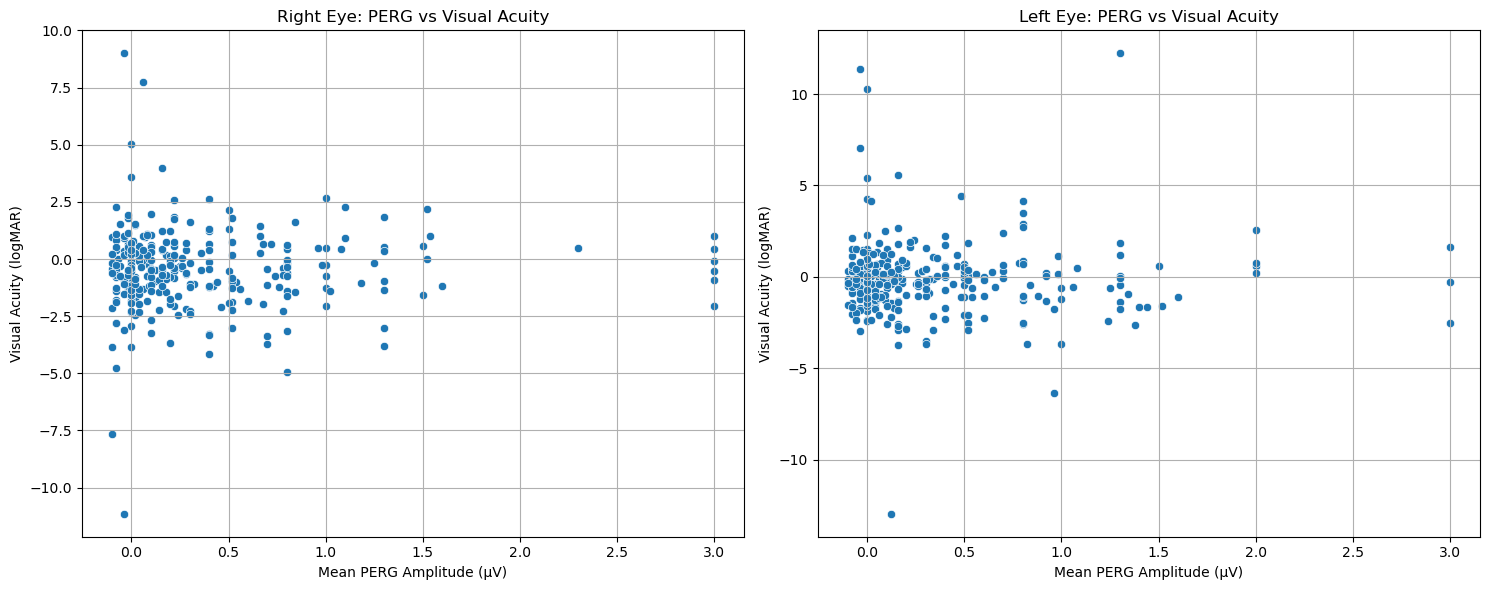

Correlation (Right Eye): r=0.011, p=0.849
Correlation (Left Eye): r=-0.008, p=0.895


In [19]:
plot_perg_va_correlation(participants_all_records)

# Second Question

**Longitudinal Analysis of PERG Signals in Follow-up Visits**
<hr>
This research question focuses on analyzing how PERG signals change over time for patients with follow-up visits. The project would involve:
Identifying patients with follow-up visits using the rep_record field.
Comparing PERG signals between initial and follow-up visits to detect any significant changes.
Analyzing how changes in PERG signals correlate with changes in visual acuity over time.
Investigating if certain diagnoses are associated with specific patterns of PERG signal changes in follow-up visits.
Examining the impact of time intervals between visits on PERG signal changes.

In [25]:
# Identify patients with follow-up visits
follow_up_patients = participants_info[participants_info['rep_record'].notna()]

In [82]:
follow_up_patients

,id_record,date,age_years,sex,diagnosis1,diagnosis2,diagnosis3,va_re_logMar,va_le_logMar,unilateral,rep_record,comments
2,3,2019-08-08,49,Female,Orbital ischemia,Systemic disorder with ocular manifestations,NaN,0.26,0.00,NaN,Id:0329 - Id:0154 - Id:0049 - Id:0271,NaN
5,6,2006-10-07,20,Male,Retinal toxicity,NaN,NaN,-0.06,0.04,NaN,Id:0112,Toxic maculopathy by isotretinoin
11,12,2003-11-05,55,Female,Chorioretinopathy Birdshot type,Inflammatory disease,NaN,0.00,0.00,NaN,Id:0150 - Id:0231 - Id:0147 - Id:0259,NaN
18,19,2014-03-26,53,Female,Macular dystrophy,Central areolar choroidal dystrophy,NaN,0.36,0.10,NaN,Id:0127,NaN
24,25,2018-01-31,38,Female,Macular dystrophy,Central areolar choroidal dystrophy,NaN,0.08,0.02,NaN,Id:0176,NaN
32,33,2022-09-21,33,Male,Torpedo maculopathy,NaN,NaN,0.08,0.02,NaN,Id:0324,NaN
48,49,2005-12-31,36,Female,Orbital ischemia,Systemic disorder with ocular manifestations,NaN,0.12,-0.08,NaN,Id:0329 - Id:0003 - Id:0154 - Id:0271,NaN
49,50,2006-08-02,27,Female,Retinitis pigmentosa,NaN,NaN,NaN,NaN,NaN,Id:0109,NaN
61,62,2004-12-11,55,Male,Normal,NaN,NaN,0.16,0.10,NaN,Id:0090,NaN
67,68,2004-08-23,17,Female,Optic neuropathy,NaN,NaN,0.40,0.30,NaN,Id:0161,NaN


In [39]:
# Analyze PERG signals for patients with follow-up visits
longitudinal_data = []

for _, patient in follow_up_patients.iterrows():
    initial_id = patient['id_record']
    follow_up_ids = [int(id.split(':')[-1]) for id in patient['rep_record'].split(' - ')]
    
    try:
        initial_data = load_patient_data(initial_id)
        initial_perg = calculate_mean_perg(initial_data)
        initial_va = patient[['va_re_logMar', 'va_le_logMar']]
        
        for follow_up_id in follow_up_ids:
            follow_up_data = load_patient_data(follow_up_id)
            follow_up_perg = calculate_mean_perg(follow_up_data)
            follow_up_info = participants_info[participants_info['id_record'] == follow_up_id].iloc[0]
            follow_up_va = follow_up_info[['va_re_logMar', 'va_le_logMar']]
            
            time_diff = pd.to_datetime(follow_up_info['date']) - pd.to_datetime(patient['date'])
            
            longitudinal_data.append({
                'patient_id': initial_id,
                'follow_up_id': follow_up_id,
                'diagnosis': patient['diagnosis1'],
                'time_interval': time_diff.days,
                're_perg_change': follow_up_perg['mean_re_perg'] - initial_perg['mean_re_perg'],
                'le_perg_change': follow_up_perg['mean_le_perg'] - initial_perg['mean_le_perg'],
                're_va_change': follow_up_va['va_re_logMar'] - initial_va['va_re_logMar'],
                'le_va_change': follow_up_va['va_le_logMar'] - initial_va['va_le_logMar']
            })
    except FileNotFoundError:
        continue

longitudinal_df = pd.DataFrame(longitudinal_data)


In [28]:
longitudinal_df.head()

,patient_id,follow_up_id,diagnosis,time_interval,re_perg_change,le_perg_change,re_va_change,le_va_change
0,3,329,Orbital ischemia,-2072,-0.125294,-1.748627,-0.16,0.00
1,3,154,Orbital ischemia,-4669,1.905098,-1.076275,-0.14,-0.04
2,3,49,Orbital ischemia,-4968,1.063922,0.038039,-0.14,-0.08
3,3,271,Orbital ischemia,-4291,0.537059,-2.097451,-0.18,-0.04
4,6,112,Retinal toxicity,-303,-6.446275,5.285490,-0.02,-0.08


In [69]:
# Analyze correlation between PERG changes and visual acuity changes
def plot_perg_va_correlation(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.scatterplot(x='re_perg_change', y='re_va_change', data=df, ax=ax1)
    ax1.set_title('Right Eye: PERG Change vs Visual Acuity Change')
    ax1.set_xlabel('PERG Amplitude Change (μV)')
    ax1.set_ylabel('Visual Acuity Change (logMAR)')
    ax1.grid(True)
    
    sns.scatterplot(x='le_perg_change', y='le_va_change', data=df, ax=ax2)
    ax2.set_title('Left Eye: PERG Change vs Visual Acuity Change')
    ax2.set_xlabel('PERG Amplitude Change (μV)')
    ax2.set_ylabel('Visual Acuity Change (logMAR)')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

    df = df.dropna(subset=['re_perg_change', 'le_perg_change', 're_va_change', 'le_va_change'])
    corr_re = stats.pearsonr(df['re_perg_change'], df['re_va_change'])
    corr_le = stats.pearsonr(df['le_perg_change'], df['le_va_change'])
    
    print(f"Correlation (Right Eye): r={corr_re[0]:.3f}, p={corr_re[1]:.3f}")
    print(f"Correlation (Left Eye): r={corr_le[0]:.3f}, p={corr_le[1]:.3f}")

# Analyze PERG changes by diagnosis
def plot_perg_changes_by_diagnosis(df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='diagnosis', y='re_perg_change', data=df)
    plt.title('PERG Changes by Diagnosis (Right Eye)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='diagnosis', y='le_perg_change', data=df)
    plt.title('PERG Changes by Diagnosis (Left Eye)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [67]:
# Analyze impact of time interval on PERG changes
def plot_time_interval_impact(df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='time_interval', y='re_perg_change', data=df)
    plt.title('Impact of Time Interval on PERG Changes (Right Eye)')
    plt.xlabel('Time Interval (days)')
    plt.ylabel('PERG Amplitude Change (μV)')
    plt.tight_layout()
    plt.show()

    df = df.dropna(subset=['time_interval', 're_perg_change'])
    corr_time = stats.pearsonr(df['time_interval'], df['re_perg_change'])
    print(f"Correlation (Time Interval vs PERG Change for RE): r={corr_time[0]:.3f}, p={corr_time[1]:.3f}")
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='time_interval', y='le_perg_change', data=df)
    plt.title('Impact of Time Interval on PERG Changes (Left Eye)')
    plt.xlabel('Time Interval (days)')
    plt.ylabel('PERG Amplitude Change (μV)')
    plt.tight_layout()
    plt.show()

    df = df.dropna(subset=['time_interval', 'le_perg_change'])
    corr_time = stats.pearsonr(df['time_interval'], df['le_perg_change'])
    print(f"Correlation (Time Interval vs PERG Change for LE): r={corr_time[0]:.3f}, p={corr_time[1]:.3f}")

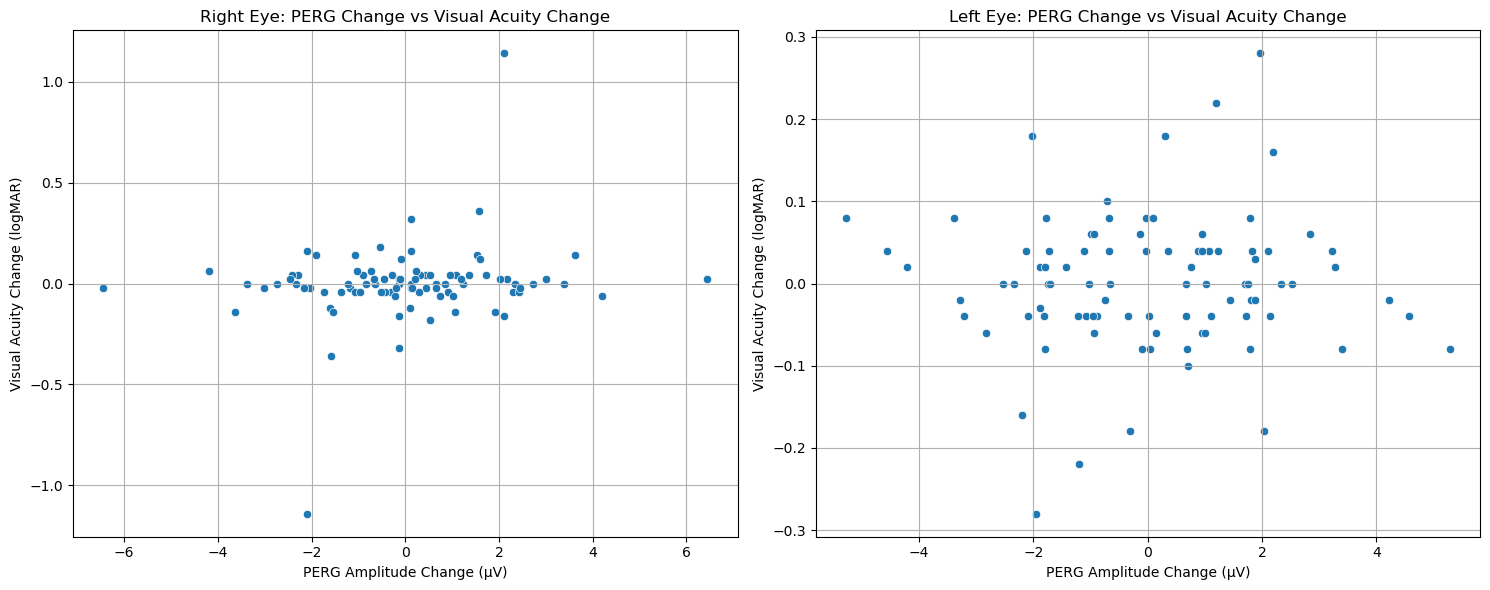

Correlation (Right Eye): r=0.173, p=0.103
Correlation (Left Eye): r=0.019, p=0.857


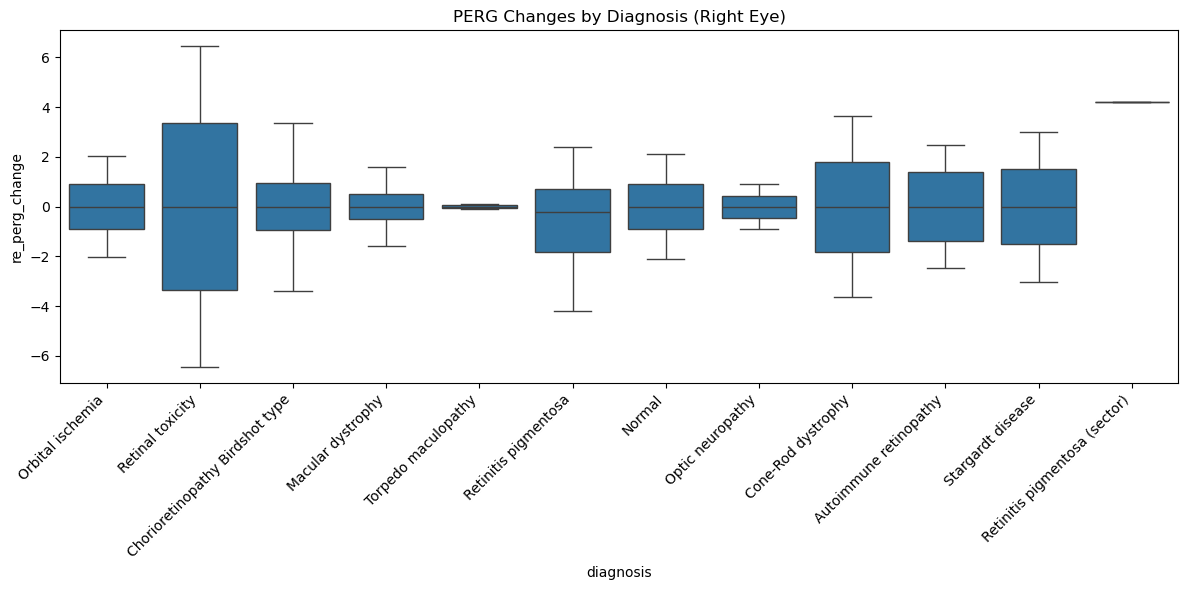

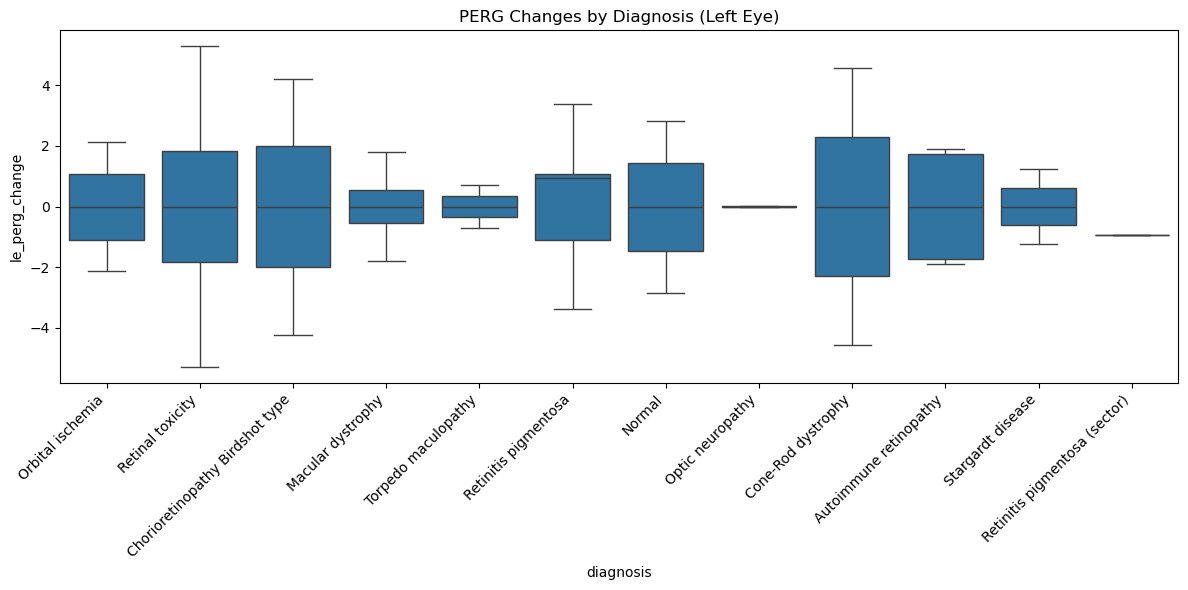

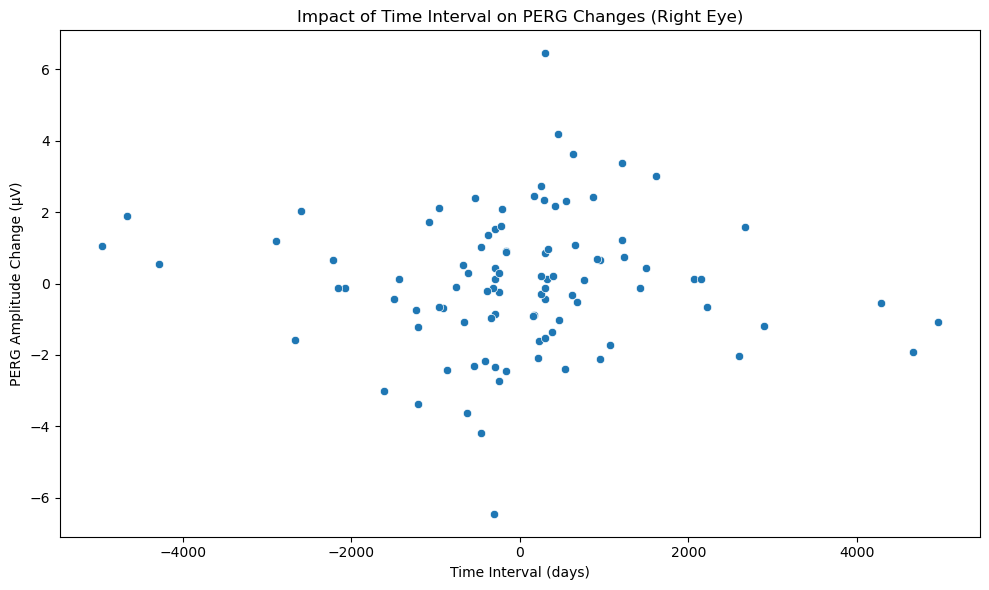

Correlation (Time Interval vs PERG Change for RE): r=-0.025, p=0.812


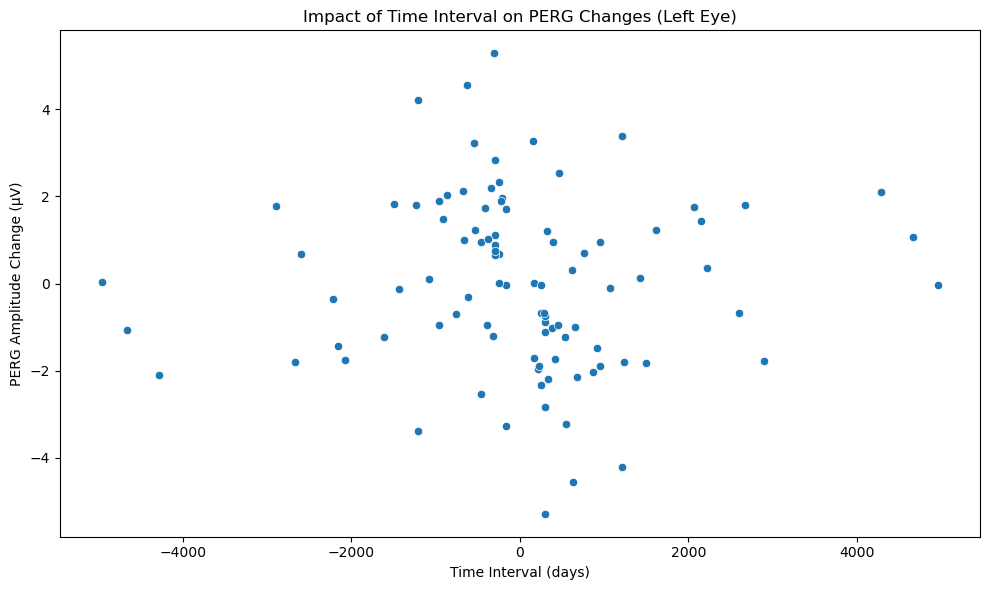

Correlation (Time Interval vs PERG Change for LE): r=-0.003, p=0.975


In [71]:
# Run analyses
plot_perg_va_correlation(longitudinal_df)
plot_perg_changes_by_diagnosis(longitudinal_df)
plot_time_interval_impact(longitudinal_df)

In [162]:
participants_merged = participants_all_records.copy()

longitudinal_mean_change = longitudinal_df.groupby(['patient_id']).agg(
    # diagnosis = ('diagnosis'),
    re_perg_mean = ('re_perg_change', 'mean'),
    le_perg_mean = ('le_perg_change', 'mean'),
    re_va_mean = ('re_va_change', 'mean'),
    le_va_mean = ('le_va_change', 'mean'),
).reset_index().rename(columns={'patient_id': 'id_record'})

mean_values = {'mean_re_perg_change': longitudinal_mean_change['re_perg_mean'].mean(), 
               'mean_le_perg_change': longitudinal_mean_change['le_perg_mean'].mean()}
participants_merged = pd.merge(left=participants_merged, right=longitudinal_mean_change[['id_record', 're_perg_mean', 'le_perg_mean']], how='left', on='id_record')\
                                                                .rename(columns={
                                                                    're_perg_mean': 'mean_re_perg_change',
                                                                    'le_perg_mean': 'mean_le_perg_change'
                                                                }).fillna(value=mean_values)

In [184]:
participants_ = participants_merged.copy()

participants_['sex'] = participants_['sex'].apply(lambda x: 0 if x == 'Female' else 1)
participants_['diagnosis_bi'] = participants_['diagnosis_bi'].apply(lambda x: 0 if x == "Normal" else 1)
participants_ = participants_.drop(columns=['id_record', 'date', 'diagnosis1'])
participants_.head()

,age_years,sex,va_re_logMar,va_le_logMar,diagnosis_bi,mean_re_perg,mean_le_perg,mean_re_perg_change,mean_le_perg_change
0,13,1,-0.08,0.06,0,-1.406667,1.853333,2.018587e-18,1.614870e-17
1,13,0,0.18,0.16,1,-0.892549,-2.576863,2.018587e-18,1.614870e-17
2,43,0,0.02,0.09,1,-1.690980,2.511373,2.018587e-18,1.614870e-17
3,47,0,0.10,0.10,0,1.981569,1.527190,2.018587e-18,1.614870e-17
4,43,1,-0.10,0.07,0,-0.448039,-0.933725,2.018587e-18,1.614870e-17


In [186]:
X = participants_.drop(columns=['diagnosis_bi'])
y = participants_[['diagnosis_bi']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [188]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2f}")

C:\Users\ual-laptop\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Confusion Matrix:
[[11 13]
 [ 9 42]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.46      0.50        24
           1       0.76      0.82      0.79        51

    accuracy                           0.71        75
   macro avg       0.66      0.64      0.65        75
weighted avg       0.70      0.71      0.70        75

Accuracy Score: 0.71


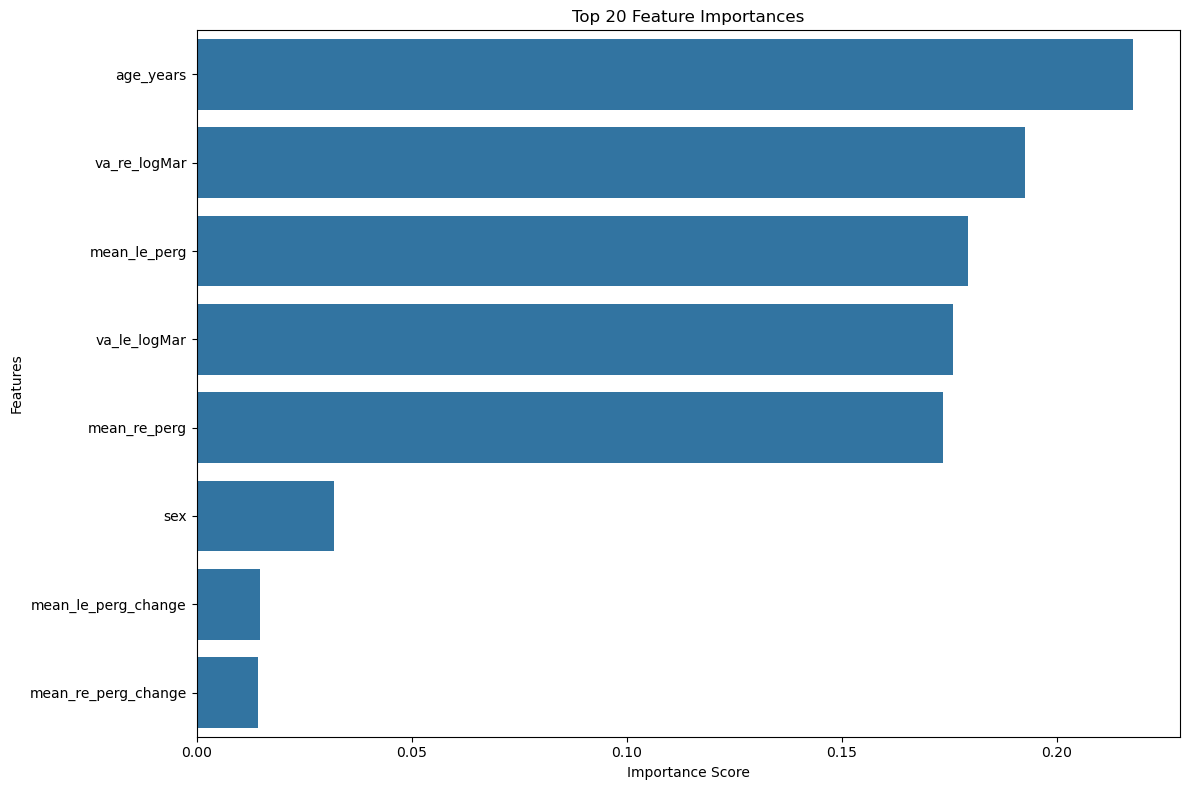

In [190]:
importances = rf_classifier.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x=feature_importances[:20], y=feature_importances.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [220]:
xgb_classifier = XGBClassifier(n_estimators=500, random_state=101, learning_rate=0.01)
xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2f}")


Confusion Matrix:
[[15  9]
 [15 36]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.62      0.56        24
           1       0.80      0.71      0.75        51

    accuracy                           0.68        75
   macro avg       0.65      0.67      0.65        75
weighted avg       0.70      0.68      0.69        75

Accuracy Score: 0.68


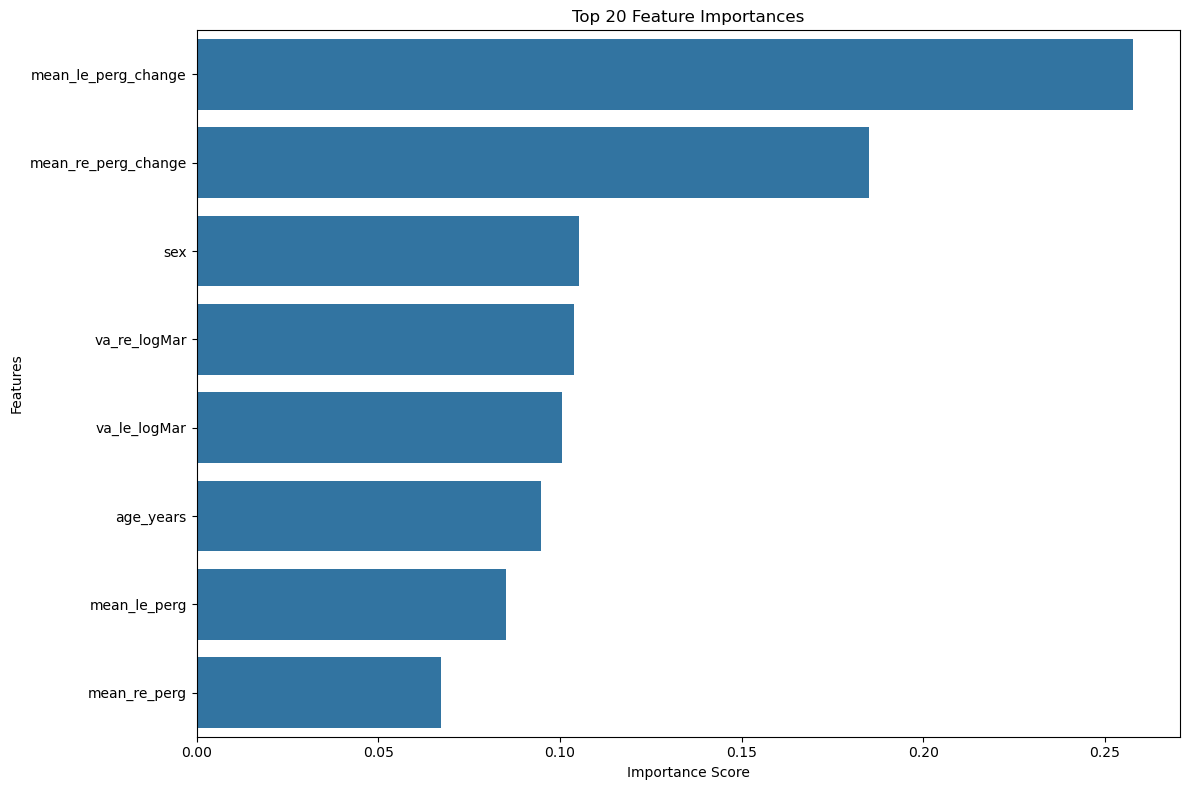

In [194]:
importances = xgb_classifier.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x=feature_importances[:20], y=feature_importances.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [224]:
# participants_.to_csv('participants_merged_a1.csv', index=False)

In [ ]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])